In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#export
from uti.newLeaner_05b import *

In [17]:
train_ds,valid_ds = get_dataset(*get_data())
data = Databunch(*get_dl(train_ds,valid_ds,bs=64),c=10)
loss_func = F.cross_entropy

/home/jupyter/.fastai/data/mnist.pkl.gz


In [18]:
#export
class Recorder(Callback):
    _order = 1
    
    def __init__(self,beta=0.9):
        self.beta = beta
        self.losses, self.lrs = [], []
        self.avg_loss = 0.
        self.count = 0    
        
    def begin_batch(self):
        self.count += 1
    
    def after_loss(self):
        if self.learn.in_train:
            with torch.no_grad():
                self.losses.append(self.smooth_loss())
                self.lrs.append(self.learn.opt.param_groups[0]['lr'])
            
    def smooth_loss(self):
        loss = self.learn.loss.item()
        self.avg_loss = self.avg_loss * self.beta + loss * (1-self.beta)
        smooth_loss = self.avg_loss / (1-self.beta ** self.count)
        return smooth_loss
         
            
    def plot_lr(self):
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)

In [19]:
learn = NewLearner(*get_model(data),loss_func,data,cbs=[Recorder(),Accuracy()])

In [20]:
learn.fit(2)

Train: 0.31377536058425903, 0.903659999370575
Valid: 0.13892687857151031, 0.9617999792098999
 
Train: 0.1437414139509201, 0.9558200240135193
Valid: 0.12952928245067596, 0.9624000191688538
 


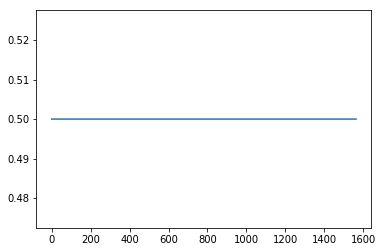

In [21]:
learn.cbs[2].plot_lr()

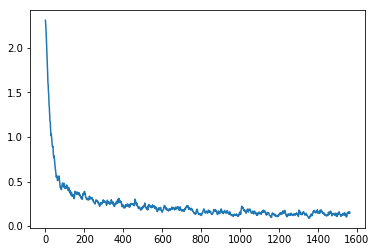

In [22]:
learn.cbs[2].plot_loss()

Recorder works fine, now we just need to re implement LR_find using new Leaner

In [23]:
#export
class LR_find(Callback):
    def begin_fit(self,start=1e-8,end=10.,beta=0.98):
        self.start, self.end, self.beta = start, end, beta
        self.current_lr = start
        self.ratio = (end / start) ** (1 / (len(self.learn.data.train_dl)-1))
        self.lr = []
        self.losses = []
        self.best_loss = 0.
        self.avg_loss = 0.
        self.smooth_loss = 0.
        self.batch_num = 0
        
    def begin_batch(self):
        self.batch_num += 1
        self.learn.opt.param_groups[0]['lr'] = self.current_lr
        
    
    def after_loss(self):
        self.loss = self.learn.loss
        self.avg_loss = self.avg_loss * self.beta + self.loss.data * (1 - self.beta)
        self.smooth_loss = self.avg_loss / (1 - self.beta ** self.batch_num) #debias
        if self.batch_num > 1 and self.smooth_loss > 4 * self.best_loss:
            raise CancelTrainException()
        if self.batch_num == 1 or self.best_loss > self.smooth_loss:
            self.best_loss = self.smooth_loss
            self.best_lr = self.current_lr
        self.losses.append(self.smooth_loss)
        self.lr.append(math.log10(self.current_lr))
        self.current_lr *= self.ratio
        
    
    def begin_validate(self):
        raise CancelTrainException()

In [24]:
lr_find = LR_find()
learn = NewLearner(*get_model(data),loss_func,data,cbs=[lr_find])

In [25]:
learn.fit(1)

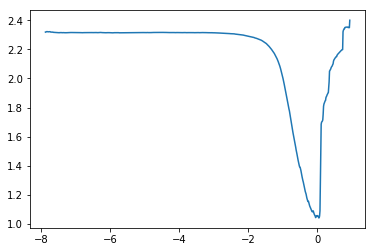

In [26]:
plt.plot(lr_find.lr[10:-5],lr_find.losses[10:-5])

In [14]:
#export
class ParaScheduler(Callback):
    _order = 1
    def __init__(self,para_name,sched_func):
        self.para_name, self.sched_func = para_name, sched_func
        
    def set_param(self,pos):
        self.learn.opt.param_groups[0][self.para_name] = self.sched_func(pos)
        
    def begin_batch(self):
        if self.learn.in_train:
            
            #cbs[0] will always be TrainEvalCallback
            #TrainEval will have current pos, eg: 2.3 epochs
            #pos = current_epochs / total_epochs, eg: 20% of training 
            
            pos = self.learn.cbs[0].n_epochs / self.learn.epochs 
            self.set_param(pos)

In [15]:
#export
from functools import partial
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos):  return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [16]:
f = sched_lin(1,2)

In [17]:
f(0.3)

1.3

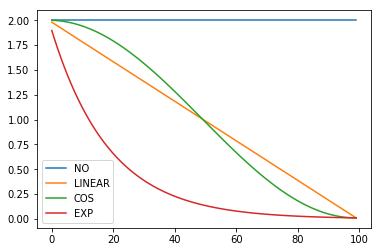

In [18]:
annealings = "NO LINEAR COS EXP".split()

torch.Tensor.ndim = property(lambda x: len(x.shape))

a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [19]:
#export
#copied from class
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + pcts)
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [20]:
f = combine_scheds([0.3,0.7],[sched_cos(0.3,0.9),sched_cos(0.9,0.2)])

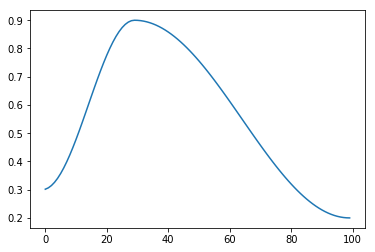

In [21]:
plt.plot(a,[f(o) for o in p])

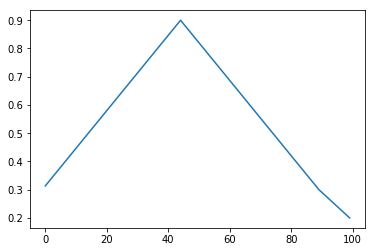

In [22]:
f_lin = combine_scheds([0.45,0.45,0.1],[sched_lin(0.3,0.9),sched_lin(0.9,0.3),sched_lin(0.3,0.2)])
plt.plot(a,[f_lin(o) for o in p])

In [23]:
cbs = [Recorder(),Accuracy(),ParaScheduler('lr',f)]

In [24]:
learn = NewLearner(*get_model(data),loss_func,data,cbs=cbs)

In [25]:
learn.fit(3)

Train: 0.3711211383342743, 0.887220025062561
Valid: 0.5444002151489258, 0.85589998960495
 
Train: 0.15582720935344696, 0.9532600045204163
Valid: 0.1482316106557846, 0.9538999795913696
 
Train: 0.0873744860291481, 0.9731400012969971
Valid: 0.1052396148443222, 0.9710999727249146
 


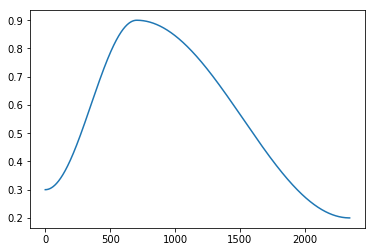

In [26]:
learn.cbs[2].plot_lr()

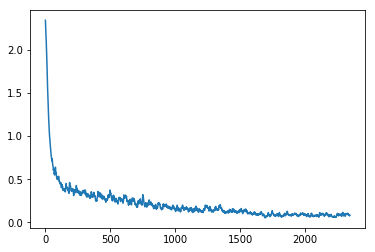

In [27]:
learn.cbs[2].plot_loss()

In [28]:
cbs = [Recorder(),Accuracy(),ParaScheduler('lr',f_lin)]
learn = NewLearner(*get_model(data),loss_func,data,cbs=cbs)
learn.fit(3)

Train: 0.3573359251022339, 0.8898400068283081
Valid: 0.2773478925228119, 0.9136999845504761
 
Train: 0.1674635112285614, 0.9478999972343445
Valid: 0.16517627239227295, 0.9484000205993652
 
Train: 0.08973529189825058, 0.972320020198822
Valid: 0.09654824435710907, 0.9711999893188477
 


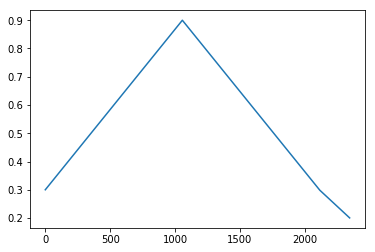

In [29]:
learn.cbs[2].plot_lr()

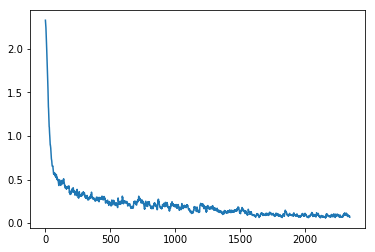

In [30]:
learn.cbs[2].plot_loss()

# Fin

Done Param scheduler, test both linear scheduler and cos scheduler, seems cos schduler is good for now.
Will re-test both after batch_norm is included and longer training time

Minor changes to Recorder, now for the loss it is ploting the exponential moving avager with beta set to 0.9 by default, roughly 10 data average window.

In [31]:
from notebook2script import *

In [33]:
notebook2script('05c_LR_Scheduler.ipynb','LR_find_Schduler')

Converted 05c_LR_Scheduler.ipynb to uti/LR_find_Schduler_05c.py
